<h1 align="center"> Particle Filter for a Dirichlet Process Mixture of Normals Model</h1>
<h4 align="center"><em>By Rick Farouni</em></h4>

## Model Specification

$$
\newcommand{\bepsilon}{\boldsymbol{\varepsilon}}
\newcommand{\bPhi}{\boldsymbol{\Phi}}
\newcommand{\bOmega}{\boldsymbol{\Omega}}
\newcommand{\bPsi}{\boldsymbol{\Psi}}
\newcommand{\bLambda}{\boldsymbol{\Lambda}}
\newcommand{\bSigma}{\boldsymbol{\Sigma}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bs}{\mathbf{s}}
\newcommand{\sy}{\mathcal{Y}}
\newcommand{\sX}{\mathcal{X}}
\newcommand{\sB}{\mathcal{B}}
\newcommand{\sG}{\mathcal{G}}
\newcommand{\sz}{\mathcal{Z}}
\newcommand{\sC}{\mathcal{C}}
\newcommand{\sK}{\mathcal{K}}
\newcommand{\sN}{\mathcal{N}}
\newcommand{\sL}{\mathcal{L}}
\newcommand{\sP}{\mathcal{P}}
\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator*{\Var}{\mathrm{Var}}
\DeclareMathOperator*{\Cov}{\mathrm{Cov}}
\DeclareMathOperator{\logit}{logit}
\DeclareMathOperator{\Diag}{Diag}
\DeclareMathOperator{\R}{\mathbb{R}}
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bh}{\mathbf{h}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bmu}{\boldsymbol{\mu}} 
\newcommand{\bbeta}{\boldsymbol{\beta}} 
\newcommand{\bvepsilon}{\boldsymbol{\epsilon}} 
$$

For subjects $i=1,2,..,T$, let $\by_i=[y_{i1},y_{i2},\ldots,y_{iD}]$ be vector of $D$ measurements for subject $i$,  where $D\ll T$. Here we assume that the subjects can be divided into $K$ clusters such that each subject (i.e. observation) belongs to one particular cluster only. That is, each observation $\by_i$ is given a cluster label $z_i \in \lbrace 1,\ldots,K\rbrace$. We specify a *Dirichlet Process Mixture of Normals* model as follows:

\begin{gather}
\begin{aligned}
G \mid \alpha &\sim \operatorname{DP}(\alpha G_0)  \\
\left(\bmu_{t},\Sigma_t\right)\mid G &\sim G \\
\by_{t}\mid \bmu_{t},\Sigma_k & \sim \operatorname{Normal}(\bmu_{t}, \Sigma_t) 
\end{aligned}
\end{gather}
where 
\begin{align*}
\alpha &  \quad \textit{is the concentration parameter}\\
G_0&=p\left(\bmu,\Sigma\right) \equiv\operatorname{Normal-Inv-Wishart}(\bmu_0, \kappa_0, \nu_0, \Lambda_0) \quad \textit{ is the centering distribution} \\
\theta_k &=\left(\bmu_k,\Sigma_k\right) \textit{  mean and covariance of observations in the kth class}\\
\Theta &= \left( \theta_1, \cdots, \theta_K \right) \textit{   collection of all K parameter vectors } \\
\sy&=\left(\by_1,\by_2,\ldots,\by_T \right) \textit{ the data consiting of all T observations}\\
\sz &= \left(z_{1}, \cdots, z_{T} \right) \textit{ vector of  class labels for all T observations}\\
\sC&=\lbrace c_1, c_2,\ldots,c_K: c_k \subseteq \lbrace1,2,\ldots,T\rbrace\rbrace  \textit{ clustering of the observations into K clusters}\\
\sN&=\lbrace N_1,N_2,\ldots,N_K: N_k= \sum_{i=1}^{T}\delta(z_i=k) \rbrace   \textit{  number of observations in each cluster}
\end{align*}
       

## Forward Simulation

We can generate data from the DPMN model using the polya urn scheme. First we code the helping functions in Julia:

In [74]:
versioninfo()

Julia Version 0.5.0-dev+1491
Commit 41fb1ba (2015-11-27 16:54 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


In [37]:
using Distributions, Combinatorics, Logging

function sample_from_G₀!(μ,Σ,zᵢ)
  #sample from the centering distribution
  push!(Σ,rand(InverseWishart(ν₀, Λ₀))) # append to vector Σ
  push!(μ,rand(MultivariateNormal(μ₀,Σ[zᵢ]/κ₀))) # append to vector μ
  return μ,Σ
end

function polya_urn(T, α, D)
  Z=[1] # assign first observation to first cluster
  # draw a set of parameters for the first observation
  Σ=[rand(InverseWishart(ν₀, Λ₀)) for j=1:1]
  μ=[rand(MultivariateNormal(μ₀, Σ[1]/κ₀)) for j=1:1]
  for t=2:T
    K=maximum(unique(Z)) # number of clusters
    C=[find(Z.==k) for k=1:K] # determine the clustering of  indices
    N=[size(C[k],1) for k=1:K] # compute the cardinality of each cluster
    pᵢ= map(Float64,[N,α]/ (α+t-1))#float64([N,α]/ (α+t-1)) # compute all K+1 mixing proportions
    zᵢ=rand(Categorical(pᵢ),1)[1] #sample cluster label for observation t
    push!(Z,zᵢ) # append new label
    if zᵢ> K # if new cluster is created, draw parameters from G₀
      μ,Σ = sample_from_G₀!(μ,Σ,zᵢ)
    end
  end
  return Z,μ,Σ
end

function generate_data_DPMG(T,α,D)
  #generate data for the Dirichlet Process Mixture of Gaussians model
    Z,μ,Σ=polya_urn(T,α,D) # generate parameters and labels
    K=maximum(unique(Z)) # determine the number of clusters
    C=[find(Z.==k) for k=1:K] # determine the clustering indices
    N=[size(C[k],1) for k=1:K] # compute the cardinality of each cluster
    y=[zeros(D,k) for k in N] #intialize data vector
    for k=1:K
        y[k]=rand(MultivariateNormal(μ[k], Σ[k]),N[k])
    end
    # concatenate cluster label vector with data array
    data=vcat(vcat(hcat(y...)), Z[vcat(C...)]')
    data=data[:, randperm(T)]  #permute data
    return data,μ,Σ
end


generate_data_DPMG (generic function with 1 method)

Now we generate $T=400$ three-dimensional observations under the model with the following the hyperparameters:

\begin{align*}
\alpha& =0.5  \quad \textit{the concentration parameter}\\
\bmu_0&= [0, 0, 0]   \quad \textit{prior belief about mean vector}\\
\kappa_0&= .03   \quad \textit{number of pseudo-observations ascribed to the prior}\\
\nu_0 &= 30  \quad \textit{confidence of prior belief}\\
\Lambda_0& =\mathbf{I}_3  \quad \textit{variation from the mean vector}
\end{align*}


In [51]:
α=.5# concentration parameter of DP
T=400 # number of observations
D=3 # dimension of observation

μ₀ = [0.  for i=1:D] # location: prior belief about mean vector
Λ₀ = 1.00*eye(D) #inverse scale matrix: variation from the mean vector
ν₀ = D + 27 # degrees of freedom: confidence of prior belief
κ₀ = 0.03 # number of pseudo-observations ascribed to the prior
#intialize  create 4 simulated datasets


0.03


Now we generate four datasets

In [71]:
Logging.configure(level=ERROR) #suppress warnings

datasets=[]; means=[];covariances=[] #intialize
for index=1:4
    data,μ,Σ=generate_data_DPMG(T,α,D)
    push!(datasets,data)
    push!(means,μ)
    push!(covariances,Σ)
end

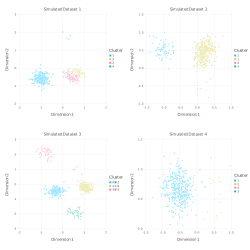

In [72]:
using Gadfly,  DataFrames

p1=Dict() #plotting scripts
for i=1:4
    p1["$i"]=plot(x=datasets[i][1,:],y=datasets[i][2,:],
                  color=int16(vec(datasets[i][D+1,:])),
                  Guide.xlabel("Dimension 1"),
                  Guide.ylabel("Dimension 2"),
                  Guide.title("Simulated Dataset $i"),
                  Guide.colorkey("Cluster"),
                  Scale.color_discrete(),
                  Theme(default_point_size=.5mm))
end

draw(SVG(25cm, 25cm),vstack(hstack(p1["1"],p1["2"]),hstack(p1["3"],p1["4"])))

Plot the 3-D views of one of the dataset (i.e. the first) and save it to file

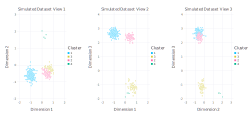

In [73]:

p2=Dict()
ind= Any[[1,2],[1,3],[2,3]]; j=1 # index of dataset
for i=1:3
    p2["$i"]=plot(x=datasets[j][ind[i][1],:],y=datasets[j][ind[i][2],:],
                  color=int16(vec(datasets[j][D+1,:])),
                  Guide.xlabel("Dimension $(ind[i][1])"),
                  Guide.ylabel("Dimension $(ind[i][2])"),
                  Guide.title("Simulated Dataset View $i"),
                  Guide.colorkey("Cluster"),
                  Scale.color_discrete(),
                  Theme(default_point_size=.5mm))
end

draw(SVG(25cm, 12cm),hstack(p2["1"],p2["2"],p2["3"]))

writedlm("data.txt",datasets[j]')
writedlm("covariance.txt",covariances[j])
writedlm("means.txt",means[j])

Note that the realizations of the Dirichlet process mixture model can show large variation in the separation of 
the mixture components. An alternative way of generating data starts with pre-setting the values of the $\bmu$ and $\Sigma$ component parameters to a fixed values. For example, $\Sigma$ can be assigned the identity matrix  and $\bmu$ can take values of the coordinates of a $D-dimensinal$ hypercube for a reasonable number of components we expect to obtain based on the value of $\alpha$. shows simulated data, for 400 observations, where the values of the $\bmu$  components are the multiset permutations of the $(\pm1.5,\pm1.5,\pm1.5)$ coordinate values. 

# Posterior Simulation

Numerical integration can be divided into deterministic methods and simulation methods. Deterministic (i.e. gird based) numerical integration methods such as adaptive quadrature can breakdown in high dimensions. Simulation methods on the other hand have higher variance but scale better in high dimensions. Two of the most important simulation based methods are Markov Chain Monte Carlo and **Sequential Monte Carlo**. For posterior inference on the selected dataset, we consider a Sequential Monte Carlo method known as **Sequential Importance Resampling** or the Particle Filter.


Let $\bz_{1:T}=\lbrace z_1,z_2,\ldots,z_T\rbrace$ and $\by_{1:T}=\lbrace \by_1,\by_2,\ldots,\by_T \rbrace$  denote the latent cluster labels and the set of observations up to time $T$.  The posterior distribution of the cluster labels is 

\begin{align}
\pi(\bz_{1:T} \mid \by_{1:T})=\frac{p(\bz_{1:T}, \by_{1:T})}{p(\by_{1:T})}=\frac{p(\by_{1:T}\mid \bz_{1:T} )p(\bz_{1:T})}{p(\by_{1:T})}
\end{align}

As $T$ increases, we obtain a sequence of probability densities of increasing dimension, namely $\lbrace \pi_T(\bz_{1:T}\mid \by_{1:T}) \rbrace_{T \in \mathbb{N}}$. Sequential Monte Carlo methods sample sequentially from  $\lbrace \pi_T(\bz_{1:T}\mid \by_{1:T}) \rbrace_{T \in \mathbb{N}}$ providing an approximation of each target distribution $\pi(\bz_{1:T}\mid \by_{1:T})$ and an estimate of its corresponding normalizing constant $Z_T=p( \by_{1:T})$. \\

The Particle Filter algorithm extends Sequential Importance Sampling method, which in turn builds upon **Importance Sampling**, which in turn is a modification of Monte Carlo simulation methods. Each of the four methods has been developed to overcome a specific type of problem. The four problems are basically concerned with the target posterior specified above.



### 1. Monte Carlo Simulation

**Problem 1** The target distribution is impossible to compute in closed-form

**Solution** We can simulate the target distribution using random samples (i.e. particles) drawn from it. More specifically, for particles, $\bz_{1:T}^{(i)}\sim \pi(\bz_{1:T} \mid \by_{1:T})$ for $i=1,...,N$, the perfect Monte Carlo approximation is:
\begin{align*}
\hat \pi_N&(d\bz_{1:T} \mid \by_{1:T}) = \frac{1}{N}\sum_{i=1}^{N} \delta_{\bz_{1:T}}(i)(d\bz_{1:T})
\end{align*}


### 2. Importance Sampling 

**Problem 2** The target $\pi(\bz_{1:T}\mid \by_{1:T})$ is a complex high-dimensional distribution such that sampling from it is practically impossible

**Solution** We choose a proposal distribution $q(.)$ we can sample from and reweigh the probability measure accordingly. More specifically, let

\begin{align*}
\pi(\bz_{1:T}\mid \by_{1:T})&=\frac{\left[ \frac{\pi(\bz_{1:T} \mid \by_{1:T})}{q(\bz_{1:T} \mid \by_{1:T})}\right]q(\bz_{1:T} \mid \by_{1:T})}{\int  \left[ \frac{\pi(\bz_{1:T} \mid \by_{1:T})}{q(\bz_{1:T} \mid \by_{1:T})}\right]q(\bz_{1:T} \mid \by_{1:T})d\bz_{1:T}}\\
& \propto w_T(\bz_{1:T})q(\bz_{1:T} \mid \by_{1:T})
\end{align*}

where
\begin{align*}
w_T(\bz_{1:T})&=\frac{\pi(\bz_{1:T} \mid \by_{1:T})}{q(\bz_{1:T} \mid \by_{1:T})}
\end{align*}

Now for particles, $\bz_{1:T}^{(i)} \sim q(\bz_{1:T} \mid \by_{1:T})$ for $i=1,...,N$, the Monte Carlo approximation is:

\begin{align*}
\hat{\pi}_N&(d\bz_{1:T} \mid \by_{1:T}) = \sum_{i=1}^{N} W_{T}(\bz_{1:T}^{(i)})\delta_{\bz_{1:T}}(i)(d\bz_{1:T})
\end{align*}

where the normalized importance weights are
\begin{align*}
W_{T}(\bz_{1:T}^{(i)})=\frac{w_T(\bz_{1:T}^{(i)})}{\sum_{j=1}^{N}w_T(\bz_{1:T}^{(j)})}  \quad , 
w_T(\bz_{1:T}^{(i)})&=\frac{\pi(\bz_{1:T} \mid \by_{1:T})}{q(\bz_{1:T}^{(i)} \mid \by_{1:T})}
\end{align*}



### 3.Sequential Importance Sampling

**Problem 3** The number of observations $T$ is large and the computational complexity of sampling increases at least linearly with $T$

**Solution** We can use a divide-and-conquer strategy and break the problem into smaller parts. This approach to problem solving is known as \textit{recursion}. Recursion is usually contrasted with \textit{iteration}, where we resort to repetition until a task is completed (e.g. MCMC). 


First, consider a general state space model

\begin{align*}
z_{t}\sim p(z_t \mid z_{t-1}) \quad t\geq1\\
\by_{t}\sim p(\by_t \mid z_{t}) \quad t\geq1
\end{align*}

that assumes: 


1. The Markov property of latent labels
\begin{align*}
p(z_t \mid \bz_{1:t-1},\by_{1:t-1})=p(z_t \mid z_{t-1})
\end{align*}
2. The conditional independence of observations
\begin{align*}
p(\by_{t}\mid \bz_{1:t},\by_{1:t-1})=p(\by_{t} \mid z_{t})
\end{align*}


These two assumptions imply that

\begin{align*}
p(\by_{1:T} &\mid \bz_{1:T})= \prod_{t=1}^{T} p(\by_t \mid z_{t})\\
p(\bz_{1:T} &)= \prod_{t=1}^{T} p(z_t \mid z_{(t-1)}) \qquad (p(z_{0})=c)
\end{align*}
allowing the full the posterior to be factored as such
\begin{align*}
\pi(\bz_{1:T} \mid \by_{1:T}) \propto \prod_{t=1}^{T}  p(\by_t \mid z_{t})p(z_t \mid z_{(t-1)})
\end{align*}
which gives us the following recursion relation:
\begin{align*}
\pi(\bz_{1:t} \mid \by_{1:t}) \propto p(\by_t \mid z_{t})p(z_t \mid z_{(t-1)})\pi(\bz_{1:t-1} \mid \by_{1:t-1})
\end{align*}


In sequential importance sampling, we select an importance distribution with the following recursive structure

\begin{align*}
q(\bz_{1:t} \mid \by_{1:t})&= q(\bz_t \mid \bz_{1:t-1},\by_{1:t}) q(\bz_{1:t-1} \mid \by_{1:t-1})
\end{align*}

The above decomposition implies we can at time $t$ draw particles $\bz_{1:t}^{(i)}\sim q(\bz_{1:t} \mid \by_{1:t})$ for $i=1,...,N$ by 


1. drawing samples $\bz_{1:t-1}^{(i)}$ from $q(\bz_{1:t-1} \mid \by_{1:t-1})$  
2. drawing new samples $\bz_{t}^{(i)}$ from $q(\bz_t \mid \bz_{1:t-1}^{(i)},\by_{1:t})$.


The Monte Carlo approximation of $\pi(\bz_{1:t}\mid \by_{1:t})$ at time $t$ is:
\begin{align*}
\hat{\pi}_N&(d\bz_{1:t} \mid \by_{1:t}) = \sum_{i=1}^{N} W_{t}(\bz_{1:t}^{(i)})\delta_{\bz_{1:t}}(i)(d\bz_{1:t})
\end{align*}

as a result we get the following recursion relation for the importance weights:

\begin{align*}
w_{t}(\bz_{1:t})&=\frac{\pi(\bz_{1:t} \mid \by_{1:t})}{q(\bz_{1:t} \mid \by_{1:t})}\\
&\propto \frac{p(\by_t \mid z_{t}) p(z_t \mid z_{t-1}) \pi(\bz_{1:t-1} \mid \by_{1:t-1})}{q(z_t \mid \bz_{1:t-1},\by_{1:t}) q(\bz_{1:t-1} \mid \by_{1:t-1})}\\
&\propto \frac{p(\by_t \mid z_{t}) p(z_t \mid z_{t-1})}{q(z_t \mid \bz_{1:t-1},\by_{1:t})) }w_{t-1}(\bz_{1:t-1})
\end{align*}

So if at time $t-1$ we have a set of particles and corresponding weights $\lbrace (W_{t-1}^{(i)}, \bz_{1:t-1}^{(i)}):i=1,...,N  \rbrace$  that represent the distribution $\pi(\bz_{1:t-1}\mid \by_{1:t-1})$, we can obtain a Monte Carlo approximation to $\pi(\bz_{1:t}\mid \by_{1:t})$ at time $t$ by 


1. drawing new samples $z_{t}^{(i)}$ from $q(z_t \mid \bz_{1:t-1}^{(i)},\by_{1:t})$.

2. updating the weights $\frac{p(\by_t \mid z_{t}^{(i)}) p(z_t^{(i)} \mid z_{t-1}^{(i)})}{q(z_t^{(i)} \mid \bz_{1:t-1}^{(i)},\by_{1:t})) }w_{t-1}(\bz_{1:t-1}^{(i)})$ and then normalizing them


so for  particles, $z_{t}^{(i)} \sim q(z_t \mid \bz_{1:t-1}^{(i)},\by_{1:t})$ for $i=1,...,N$, the Monte Carlo approximation for the filtering distribution is:

\begin{align*}
\hat{\pi}_N&(dz_{t} \mid \by_{1:t}) = \sum_{i=1}^{N} W_{t}^{(i)}\delta_{z_{t}}(i)(dz_{t})\\
\end{align*}

such that the set of particles and corresponding weights $\lbrace (W_{t}^{(i)}, z_{t}^{(i)}):i=1,...,N  \rbrace$  represent the distribution $\pi(z_{t}\mid \by_{1:t})$ at time $t$.


We can now focus on the marginal distribution $p(z_t \mid \by_{1:t-1})$, which has the following recursive relations that can be obtained by the Chapman-Kolmogorov equation:

\begin{align*}
\pi(z_{t} \mid \by_{1:t-1})&= \int p(z_t \mid z_{t-1}) \pi(z_{t-1} \mid \by_{1:t-1}) dz_{t-1}\\
\pi(z_{t} \mid \by_{1:t})&= \frac{p(\by_t \mid z_{t}) p(z_t \mid \by_{1:t-1})}{\int p(\by_t \mid z_{t}) p(z_t \mid \by_{1:t-1}) dz_t}
\end{align*}
based on which, the prior and posterior can be approximated as follows: 

\begin{align*}
\hat{\pi}_N&(z_{t} \mid \by_{1:t-1}) \propto \sum_{i=1}^{N} W_{t}^{(i)} p(z_t \mid z_{t-1}^{(i)})\\
\hat{\pi}_N&(z_{t} \mid \by_{1:t}) \propto \sum_{i=1}^{N} W_{t}^{(i)}p(\by_t \mid z_{t}) p(z_t \mid z_{t-1}^{(i)})
\end{align*}

which play a part in the following relationship: 

\begin{align*}
\pi(\bz_{1:t} \mid \by_{1:t})&\propto p(\bz_{1:t},\by_{1:t-1},\by_t)\\
&\propto p(\by_t \mid  \bz_{1:t},\by_{1:t-1})p(\bz_{1:t},\by_{1:t-1})\\
&\propto p(\by_t \mid  \bz_{1:t},\by_{1:t-1})p(z_t \mid \bz_{1:t-1},\by_{1:t-1})p(\bz_{1:t-1}\mid\by_{1:t-1})\\
&\propto p(\by_t \mid \bz_{1:t},\by_{1:t-1})p(z_t \mid \by_{1:t-1})
\end{align*}



### 4. Sequential Importance Resampling (The Particle Filter)

**Problem 4 The Degeneracy Problem:**  Almost all of the particles can have zero, or close to zero, weights. 

**Solution** Multiply particles with large weights and eliminate those with small weights. More specifically, resample the collection of weights and particles $\lbrace W_t^{(i)}, \bz_{1:t}^{(i)} \rbrace$ (i.e. select $\bz_{1:t}^{(i)}$ with probability $W_t^{(i)}$) to obtain $N$ new equally-weighted particles $\lbrace \frac{1}{N} , \bar{\bz}_{1:t}^{(i)}  \rbrace$. 

That is, the distribution  $\pi(\bz_{t}\mid \by_{1:t})$ which is approximated by 

\begin{align*}
\hat{\pi}_N&(d\bz_{t} \mid \by_{1:t}) = \sum_{i=1}^{N} W_{t}^{(i)}\delta_{\bz_{t}}(i)(d\bz_{t})
\end{align*}
becomes in turn approximated by a resampled empirical measure

\begin{align*}
\bar{\pi}_N&(d\bz_{t} \mid \by_{1:t}) = \sum_{i=1}^{N} \frac{N_{t}^{(i)}}{N} \delta_{\bz_{t}}(i)(d\bz_{t})= \sum_{i=1}^{N} \frac{1}{N} \delta_{\bar{\bz}_{t}}(i)(d\bz_{t})
\end{align*}

where $N_{t}^{(i)}$ is the number of offspring associated with each particle $\bz_{1:t}^{(i)}$

Several resampling algorithms have been proposed, but we will discuss the \textbf{stratified sampling algorithm} that has been proposed by [(Carpenter, 1999)](#cite-Carpenter1999). The main idea of the algorithm is to remove particles whose weights fall below a given threshold $\frac{1}{c}$ and resample from the remaining particles. The threshold is chosen so that the resampling is optimal for all unbiased resampling procedures in terms of minimizing variability in the weights introduced by resampling. 

## Particle Filter Implementation

Next we implement the Sequential Importance Resampling algorithm in *Julia*. The exact details of the implementation of the multivariate Dirichlet Process Mixture of Normals are given in [(Fearnhead, 2004)](#cite-Fearnhead2004). The authors of latter paper kindly provided *Matlab* code of their implementation. Parts of the Julia code provided below is similiar in logic to the Matlab code provided by [(Wood, 2008)](#cite-Wood2008){Wood2008}. Also, the *resample startified* function that computes the resampling step has been reimplemented with little modification.

In [1]:
function update_posterior(n,ȳ =0,ỹỹᵀ=0)
 # Gelman's Bayesian Data Analysis 3rd Edition Page 73
 # the fucntion first updates the parameters of the posterior distribution
# (μ,Σ) ∼ Normal-InverseWishart(μₙ,κₙ,Λₙ,νₙ)
 # n is the number of observations in the cluster
 # ȳ is the mean of these observations,
 # (ỹỹᵀ - n*ȳ*ȳ') is sum of squares of these observations.
  μₙ = κ₀/(κ₀+n)*μ₀ + n/(κ₀+n)*ȳ
  κₙ = κ₀+n
  νₙ = ν₀+n
  Λₙ = Λ₀ +κ₀*n/(κ₀+n)*(ȳ-μ₀)*(ȳ-μ₀)' + (ỹỹᵀ - n*ȳ*ȳ')
  #the parameters of the posterior predictive distribution of
  # new observation ỹ ∼tᵥ(μ,Σ)
  μ=μₙ
  Σ = Λₙ*(κₙ+1)/(κₙ*(νₙ-D+1))
  ν =νₙ-D+1
  return μ, Σ, ν
end


function log_posteriorpredictive(y,μ,Σ,ν,logdet_Σ=0, inv_Σ=0)
  # evaluate the the posterior predictive distribution of
  # new observation ỹ ∼tᵥ(μ,Σ)
  # Compute logdet_Σ and inv_Σ if they have not been computed before
  if logdet_Σ ==0
      logdet_Σ = logdet(Σ)
      inv_Σ = inv(Σ)
  end
  logposterior = log_Γ[ν+D]-(log_Γ[ν] + D*p_log[ν]/2 + D*log_π/2)-
        logdet_Σ/2-((ν+D)/2)*log(1+(1/(ν))*(y-μ)'*inv_Σ*(y-μ))
  return logposterior[1]
end


function resample_stratified(z,w,N)
   #Algorithm 2:Carpenter, J., Clifford, P., & Fearnhead, P. (1999).
   #Improved particle filter for nonlinear problems
    #no putative particle is resampled more than once.
    (D, M) = size(z)
    z_resampled = zeros(Int32,D,N)
    w_resampled = zeros(N)
    selected = zeros(M)
    #permute
    permuted_indx = randperm(M)
    w = w[permuted_indx]
    z = z[:,permuted_indx]
    cdf = cumsum(w)
    cdf[end]=1
    N!=1 ? p =linspace(rand(Uniform())/N,1,N):p =1
    j=1
    for i=1:N
            while j<M && cdf[j]<p[i]
            j=j+1
        end
            selected[j] = selected[j]+1
    end
    k=1
    for i=1:M
            if(selected[i]>0)
                for j=1:selected[i]
                    z_resampled[:,k] = z[:,i]
                    w_resampled[k]= w[i]
                k=k+1
            end
        end
    end
    w_resampled = w_resampled./sum(w_resampled)
    return z_resampled#returns N samples
end

function compute_putative_weights(y,t,alpha=0.4)
    # Given N particles for the first t-1 observations,
    # there are M(≥2N ) possible particles for the first t observations.
    # particle n generates  K₊(n)+1 distinct putative particles
    # iα and iω are the starting and ending indexes of the K₊(n)+1 put prtcls
    # For any given particle z 1:n , with k i distinct clusters,
    # there are k i + 1 possible allocations for the (n + 1)st ob-servation
    M = sum(K₊[:,t-1])+N # M =number of putative particles to generate.
    Wᴾ = ones(M)
    iα= 1 #starting index
    iω= K₊[1,t-1]+1 #ending index
    Zᴾ = zeros(Int32,2,M)
    for n = 1:N
        Zᴾ[1,iα:iω] = n
        Zᴾ[2,iα:iω]= 1:iω-iα+1  #num_options i.e. K₊(1)+1
        #calculate the probability of each new putative particle
        m_k = cluster_counts[1:K₊[n,t-1],n,t-1]
        # multinomial conditional prior distribution
        prior = [m_k; alpha]./(alpha + t -1)
        # update the weights so that the particles
        # (and weights) now represent the predictive distribution
        Wᴾ[iα:iω] = W[n,t-1]*prior
        posterior_predictive_p = zeros(size(prior))
        for pnp_id = 1: (iω-iα)
            (μ, Σ, ν)=update_posterior(cluster_counts[pnp_id,n,t-1],
                                        Ȳ[:,pnp_id,n,t-1],SS[:,:,pnp_id,n,t-1])
            posterior_predictive_p[pnp_id] = exp(
                      log_posteriorpredictive(y,μ,Σ,ν,logdetΣ[pnp_id,n,t-1],
                                        invΣ[:,:,pnp_id,n,t-1]))
        end
        (μ, Σ, ν)=update_posterior(0,y)
        posterior_predictive_p[end] = exp(log_posteriorpredictive(y,μ,Σ,ν))
        Wᴾ[iα:iω] = Wᴾ[iα:iω].*posterior_predictive_p
        iα= iω+1
        if n!=N
            iω= iα+K₊[n+1,t-1]
        end
    end
    Wᴾ = Wᴾ ./ sum(Wᴾ)
  return Wᴾ, Zᴾ, M
end


function find_optimal_c(Q,N)
    Q=sort(Q,rev=true)
    c = 0
    k = 0
    M = length(Q)
    k_old = -Inf
    while k_old !=k
        k_old = k
            c = (N-k)/sum(Q[k+1:end])
            k = k+ sum(Q[k+1:M]*c .> 1)
    end
    return 1/c
end


find_optimal_c (generic function with 1 method)

First please restart the kernel to redfine the variables!

In [2]:
dataset=readdlm("data.txt")'
Y=dataset[1:3,:]
const T = size(Y,2) # number of samples or time points
const D = size(Y,1) # dimension of  data
const N = 6000 # numuber of particles
#hyperparameters
const κ₀ = .05
const ν₀= D+2
const Λ₀ =0.04*eye(D)
const μ₀ = [0.  for i=1:D] #μ₀ = repmat([0],2,1)
# precomputed values
const max_class_index = T
const max_class_number = 20
const log_Γ = lgamma((1:max_class_index)/2)
const log_π = log(pi)
const p_log = log(1:max_class_index)
const class_type = Int16
#parameters θ={μₖ,Σₖ}∞
Ȳ = zeros(D,max_class_number,N,T) # means
SS = zeros(D,D,max_class_number,N,T) # sum of squares
cluster_counts = zeros(Int32,max_class_number,N,T) #
logdetΣ = zeros(max_class_number,N,T)
invΣ = zeros(D,D,max_class_number,N,T)
K₊ = ones(class_type,N,T) # number of distinct clusters
Z = zeros(class_type,N,T,2) # cluster labels (i.e. particles) where zₜ∈ {1,..,k}
W = zeros(N,T) #weights

# intialize
y = Y[:,1]
yyᵀ = y * y'
(μ, Σ, ν)=update_posterior(1,y,yyᵀ)
for i=1:N
    Ȳ[:,1,i,1] = y
    SS[:,:,1,i,1] = yyᵀ
    cluster_counts[1,i,1] = 1
    logdetΣ[1,i,1] = logdet(Σ)
    invΣ[:,:,1,i,1] =inv(Σ)
end
Z[:,1,1] = 1
W[:,1]= 1/N
cp =1  # cp is the set of current particles



1

Now we loop over the remaining observations

In [4]:
using Distributions
tic()
for t = 2:T
    println("Observation Number = ",t)
    y = Y[:,t]
    yyᵀ = y*y'
    (Wᴾ,Zᴾ, M)=compute_putative_weights(y,t) # M= \Σ^N(k_i+1).
    # The M putative weights and particles give a discrete
    # approxmation of P(z_(1:t)|y_(1:t))
    #plot_particles(Wᴾ,vec(slicedim(Zᴾ,1,2)), M,t)
    #calculate the weights of all possible putative Z at the next time-step.
    survival_threshold= find_optimal_c(Wᴾ,N) # compute survival_threshold weight
    pass_inds = Wᴾ.> survival_threshold #indices of surviving particles
    num_pass = sum(pass_inds) # number of surviving particles
    if cp == 1
        np = 2
    else
        np = 1
    end
    Z[1:num_pass,1:t-1,np] = Z[vec(Zᴾ[1,pass_inds]),1:t-1,cp]
    Z[1:num_pass,t,np] = Zᴾ[2,pass_inds]
    #weight of the propagated particles is kept unchanged
    W[1:num_pass,t]= Wᴾ[pass_inds]
    # weight of resampled particles is set to the survival_threshold weight
    W[num_pass+1:end,t]= survival_threshold
    #resample the M possible particles to produce N particles for first t obs
    selected_Zᴾ = resample_stratified(Zᴾ[:,!pass_inds],Wᴾ[!pass_inds],N-num_pass)
    max_K₊ = maximum(K₊[:,t-1])+1  # number of possible allocat for next cluster
    for npind = 1:N
        if npind ≤  num_pass
            originating_particle_id = Zᴾ[1,pass_inds][npind]
            class_id_y = Zᴾ[2,pass_inds][npind]
        else
            originating_particle_id = selected_Zᴾ[1,npind-num_pass]
            class_id_y = selected_Zᴾ[2,npind-num_pass]
            Z[npind,1:t,np] = [Z[originating_particle_id,1:t-1,cp] ,class_id_y]
        end
        originating_particle_K₊ = K₊[originating_particle_id,t-1]
        new_count = cluster_counts[class_id_y,originating_particle_id,t-1]+1
        if new_count == 1
            K₊[npind,t] = originating_particle_K₊+1
        else
            K₊[npind,t] = originating_particle_K₊
        end
        cluster_counts[1:max_K₊,npind,t]= cluster_counts[1:max_K₊,originating_particle_id,t-1]
        cluster_counts[class_id_y,npind,t] = new_count
        old_mean = Ȳ[:,class_id_y,originating_particle_id,t-1]
        Ȳ[:,1:max_K₊,npind,t] = Ȳ[:,1:max_K₊,originating_particle_id,t-1]
        Ȳ[:,class_id_y,npind,t] =  old_mean + (1/new_count)*(y - old_mean)
        SS[:,:,1:max_K₊,npind,t]= SS[:,:,1:max_K₊,originating_particle_id,t-1]
        SS[:,:,class_id_y,npind,t] = SS[:,:,class_id_y,originating_particle_id,t-1] + yyᵀ
        (μ,Σ,ν)=update_posterior(new_count,Ȳ[:,class_id_y,npind,t],SS[:,:,class_id_y,npind,t])
        logdetΣ[1:max_K₊,npind,t] = logdetΣ[1:max_K₊,originating_particle_id,t-1]
        logdetΣ[class_id_y,npind,t] = logdet(Σ)
        invΣ[:,:,1:max_K₊,npind,t] = invΣ[:,:,1:max_K₊,originating_particle_id,t-1]
        invΣ[:,:,class_id_y,npind,t]=inv(Σ)
    end
    cp = np    
end
toc()

Observation Number = 2

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 [inlined code] from range.jl:83
 in anonymous at no file:0
 [inlined code] from essentials.jl:114
 in include_string at loading.jl:355
 in execute_request_0x535c5df2 at /home/rick/.julia/v0.5/IJulia/src/execute_request.jl:177
 [inlined code] from dict.jl:723
 in eventloop at /home/rick/.julia/v0.5/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:435
while loading In[4], in expression starting on line 4


Observation Number = 3

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 [inlined code] from range.jl:83
 in anonymous at no file:0
 [inlined code] from essentials.jl:114
 in include_string at loading.jl:355
 in execute_request_0x535c5df2 at /home/rick/.julia/v0.5/IJulia/src/execute_request.jl:177
 [inlined code] from dict.jl:723
 in eventloop at /home/rick/.julia/v0.5/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:435
while loading In[4], in expression starting on line 4



Observation Number = 4
Observation Number = 5
Observation Number = 6
Observation Number = 7
Observation Number = 8
Observation Number = 9
Observation Number = 10
Observation Number = 11
Observation Number = 12
Observation Number = 13
Observation Number = 14
Observation Number = 15
Observation Number = 16
Observation Number = 17
Observation Number = 18
Observation Number = 19
Observation Number = 20
Observation Number = 21
Observation Number = 22
Observation Number = 23
Observation Number = 24
Observation Number = 25
Observation Number = 26
Observation Number = 27
Observation Number = 28
Observation Number = 29
Observation Number = 30
Observation Number = 31
Observation Number = 32
Observation Number = 33
Observation Number = 34
Observation Number = 35
Observation Number = 36
Observation Number = 37
Observation Number = 38
Observation Number = 39
Observation Number = 40
Observation Number = 41
Observation Number = 42
Observation Number = 43
Observation Number = 44
Observation Number = 

317.43396728

.43396728 seconds


In [5]:

Ztrue=int16(dataset[4,:])

label_weights=Dict()
for t = 1:T
label_index=[find(Z[:,t,2].==i) for i=1:maximum(Z[:,t,2])]
label_weights["$t"]=[sum(W[:,t][label_index[i]]) for i=1:maximum(Z[:,t,2])]
end
Zpred=zeros(Int16,T)
for t = 1:T
  Zpred[t] =  findfirst(label_weights["$t"].==maximum(label_weights["$t"]))
end


Now we plot the results of data clustering using Dirichlet Process Mixture of Normals
model.

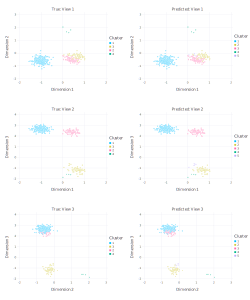

In [10]:
using Gadfly

p1=Dict();ind=Any[[1,2],[1,3],[2,3]] # index of dataset
for i=1:3
    p1["$i"]=plot(x=Y[ind[i][1],:],y=Y[ind[i][2],:],
                  color=Ztrue,
                  Guide.xlabel("Dimension $(ind[i][1])"),
                  Guide.ylabel("Dimension $(ind[i][2])"),
                  Guide.title("True: View $i"),
                  Guide.colorkey("Cluster"),
                  Scale.color_discrete(),
                  Theme(default_point_size=.5mm))
end

p2=Dict()
for i=1:3
    p2["$i"]=plot(x=Y[ind[i][1],:],y=Y[ind[i][2],:],
                  color=Zpred,
                  Guide.xlabel("Dimension $(ind[i][1])"),
                  Guide.ylabel("Dimension $(ind[i][2])"),
                  Guide.title("Predicted: View $i"),
                  Guide.colorkey("Cluster"),
                  Scale.color_discrete(),
                  Theme(default_point_size=.5mm))
end

draw(SVG(25cm, 30cm),hstack(vstack(p1["1"],p1["2"],p1["3"]),vstack(p2["1"],p2["2"],p2["3"])))



As can be seen, whereas the true number of clusters is four, the mean number of clusters that the posterior inference gave was five. It should be noted that the mean of the posterior distribution is just a point summary of the uncertainty that is inherent in the inference and that a more complete picture is provided by the entire distribution of the number of clusters. Moreover, the DPMN model assumes an infinite number of clusters and for finite data the expected number of clusters is a function of the concentration parameter that we set to $\alpha=0.5$.

<!--bibtex

@article{Fearnhead2004,
author = {Fearnhead, Paul},
journal = {Statistics and Computing},
number = {1},
pages = {11--21},
title = {{Particle filters for mixture models with an unknown number of components}},
volume = {14},
year = {2004}
}
-->